Not shown on the website. Added via [!4730](https://gitlab.opengeosys.org/ogs/ogs/-/merge_requests/4730).

In [1]:
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ogstools.logparser import (
    analysis_time_step,
    fill_ogs_context,
    parse_file,
    time_step_vs_iterations,
)

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
from pathlib import Path

out_dir_base = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir_base.exists():
    out_dir_base.mkdir(parents=True)

print("base output directory is", out_dir_base)

base output directory is _out


In [4]:
def get_out_dir(case):
    return out_dir_base / Path(case).parent

# Considered cases

1. base case
2. `<linear>true</linear>`
    * requires that global matrices `M`, `K` and right-hand side vector `b` assembled by the `ComponentTransport` process do not change over time (and do not depend on the solution)
    * requires that BCs and STs do not depend on the solution
    * performs only **one non-linear iteration per timestep**
    * `ComponentTransport` process **caches assembled global matrices** (no re-assembly necessary)
3. `<linear>true</linear>` and `<linear_solver_compute_only_upon_timestep_change>true</linear_solver_compute_only_upon_timestep_change>`
    * requires additionally, that also the BC and ST contributions to the global matrices do not change over time (no time- or solution-dependent BCs or STs!)
    * LU decomposition or preconditioner is **computed only upon timestep change**
    * only implemented for linear solvers from the Eigen library, so far

* both for an iterative (BiCGSTAB with ILUT preconditioner) and a direct linear solver (LU)
* note: ILUT is a rather expensive preconditioner. Optimization (3.) might accelerate ILUT much more than a cheaper preconditioner.

In [5]:
cases = [
    ["1 base", "./1d_decay_chain_GIA.prj"],
    ["2 linear", "linear/1d_decay_chain_GIA.xml"],
    ["3 linear & dt", "linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml"],
    ["4 LU", "SparseLU/1d_decay_chain_GIA.xml"],
    ["5 LU & linear", "SparseLU_linear/1d_decay_chain_GIA.xml"],
    [
        "6 LU & linear & dt",
        "SparseLU_linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml",
    ],
    ["7 varying dt", "varying_dt/1d_decay_chain_GIA.xml"],
    ["8 varying dt & linear", "varying_dt_linear/1d_decay_chain_GIA.xml"],
    [
        "9 varying dt & linear & dt",
        "varying_dt_linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml",
    ],
]

# Running OGS

In [6]:
for _name, case in cases:
    outdir = get_out_dir(case)
    if not outdir.exists():
        outdir.mkdir(parents=True)
        with (outdir / ".gitignore").open(mode="w") as fh:
            fh.write("*\n")

    print(f"running case {case}")
    with (outdir / "ogs-out.txt").open(mode="w") as fh:
        subprocess.run(
            ["ogs", "-o", outdir, case], check=True, stdout=fh, stderr=subprocess.STDOUT
        )

running case ./1d_decay_chain_GIA.prj
running case linear/1d_decay_chain_GIA.xml
running case linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml
running case SparseLU/1d_decay_chain_GIA.xml
running case SparseLU_linear/1d_decay_chain_GIA.xml
running case SparseLU_linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml
running case varying_dt/1d_decay_chain_GIA.xml
running case varying_dt_linear/1d_decay_chain_GIA.xml
running case varying_dt_linear_compute_only_on_dt_change/1d_decay_chain_GIA.xml


# Process log files

In [7]:
stats = []
exec_times = []

for _name, case in cases:
    outdir = get_out_dir(case)
    logfile = outdir / "ogs-out.txt"

    records = parse_file(logfile)

    dfa = pd.DataFrame(records)
    dfb = fill_ogs_context(dfa)
    dfc = time_step_vs_iterations(dfb)
    dfd = analysis_time_step(dfa)
    dfd = dfd.droplevel("mpi_process")
    dfe = dfd.join(dfc)
    dfe = dfe.drop(0)  # remove timestep 0 (only output)

    exec_times.append(dfa["execution_time"].max())

    stats.append(dfe)

/home/lehmannc/prog/py-venvs/ogs-local-release-build/lib/python3.11/site-packages/ogs6py/log_parser/common_ogs_analyses.py:170: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_step'] = df.groupby('mpi_process')[['time_step']].fillna(method='ffill').fillna(value=0)
/home/lehmannc/prog/py-venvs/ogs-local-release-build/lib/python3.11/site-packages/ogs6py/log_parser/common_ogs_analyses.py:170: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_step'] = df.groupby('mpi_process')[['time_step']].fillna(method='ffill').fillna(value=0)
/home/lehmannc/prog/py-venvs/ogs-local-release-build/lib/python3.11/site-packages/ogs6py/log_parser/common_ogs_analyses.py:173: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

In [8]:
# merge stats dataframes
df_stats = pd.DataFrame()
# df_stats = stats[0].copy()
# df_stats["case_name"] = cases[0][0]

for (name, _case), stat in zip(cases, stats):
    tmp = stat.copy()
    tmp["case_name"] = name
    df_stats = pd.concat([df_stats, tmp])

df_stats = df_stats.reset_index()
df_stats = df_stats.set_index(["case_name", "time_step"])

# Number of timesteps

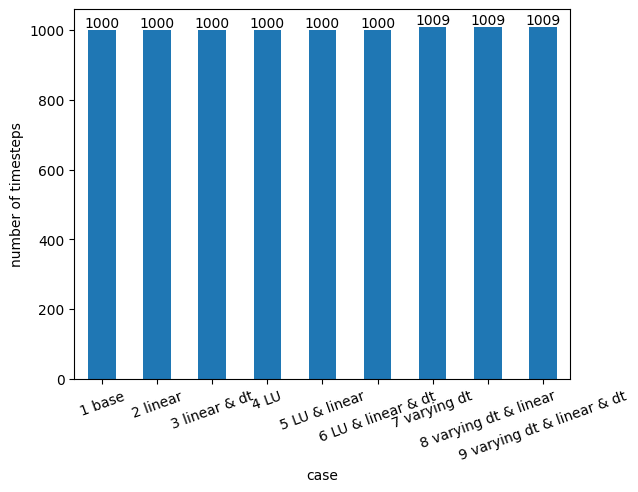

In [9]:
ax = (
    df_stats.reset_index("time_step")
    .groupby("case_name")
    .max()
    .plot(
        y="time_step",
        kind="bar",
        legend=False,
        rot=20,
        xlabel="case",
        ylabel="number of timesteps",
    )
)

for container in ax.containers:
    ax.bar_label(container)

# Non-linear solver iterations per timestep

In [10]:
df_it_num = df_stats["iteration_number"].groupby("case_name").agg(["min", "max"])

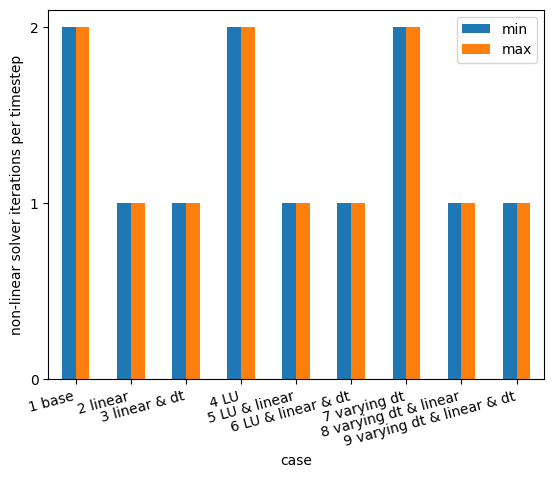

In [11]:
# ax = df_it_num.plot();
ax = df_it_num.plot(kind="bar")
ax.set_ylabel("non-linear solver iterations per timestep")
ax.set_xlabel("case")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax.set_yticks([0, 1, 2])

In [12]:
assert np.all(df_it_num["min"] == df_it_num["max"])
# attention: depends on the order of cases!
assert np.all(df_it_num["max"].values == [2, 1, 1, 2, 1, 1, 2, 1, 1])  # noqa: PD011

* with `<linear>true<linear>` only one non-linear iteration is done per timestep.

# Total execution time

Text(0.5, 0, 'case')

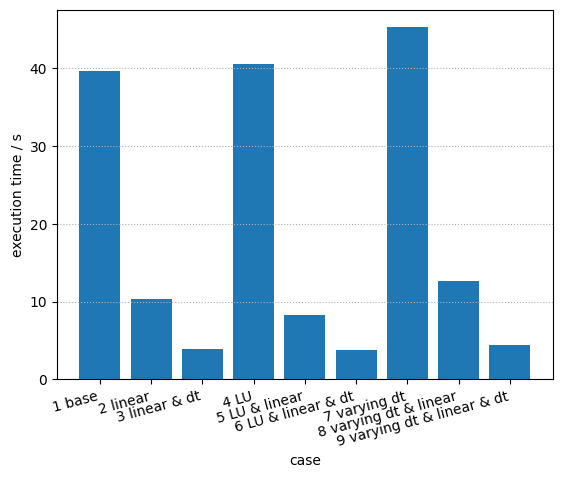

In [13]:
fig, ax = plt.subplots()

ax.bar(list(range(len(cases))), height=exec_times)
ax.set_xticks(list(range(len(cases))))
ax.set_xticklabels([name for name, case in cases], rotation=15, ha="right")
ax.set_ylabel("execution time / s")
ax.grid(axis="y", ls=":")
ax.set_xlabel("case")

# Duration of timesteps

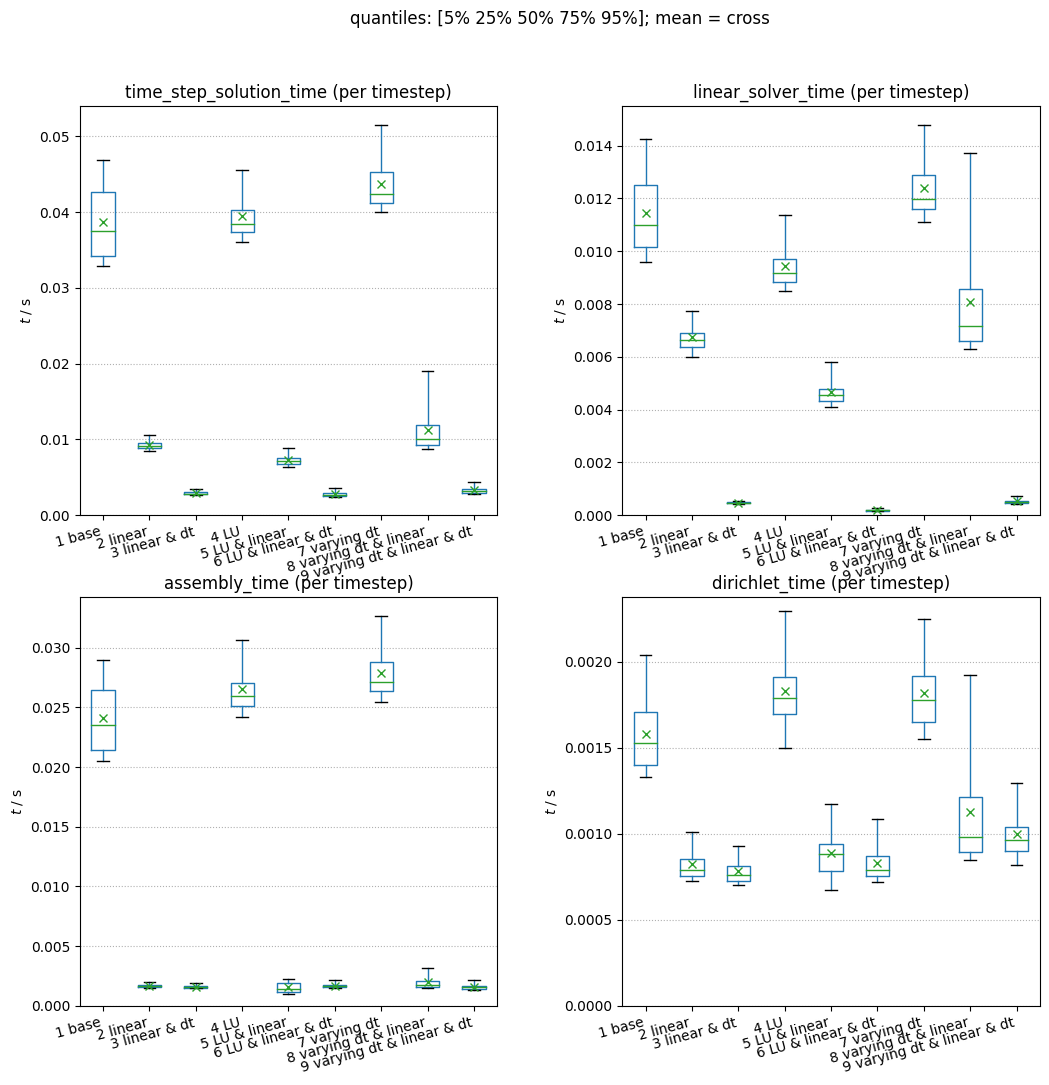

In [14]:
axs = df_stats.boxplot(
    column=[
        "time_step_solution_time",
        "linear_solver_time",
        "assembly_time",
        "dirichlet_time",
    ],
    by="case_name",
    showfliers=False,
    notch=False,
    whis=(5, 95),
    showmeans=True,
    meanprops={"marker": "x", "color": "r"},
    sharex=False,
    sharey=False,
    rot=15,
)
# ax.set_xlabel("case");
# ax.set_ylabel("timestep solution time / s");
for ax in axs.ravel():
    # ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    ax.set_xlabel("")
    ax.set_ylabel("$t$ / s")
    ax.set_ylim(0)
    ax.grid(axis="y", ls=":")
    ax.grid(axis="x", ls="")
    ax.set_title(ax.get_title() + " (per timestep)")
# ax.set_title("");
# ax.set_suptitle("");
fig = axs.ravel()[0].get_figure()
fig.suptitle("quantiles: [5% 25% 50% 75% 95%]; mean = cross")
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3)

# Speedups

## Total execution time

In [15]:
speedups = np.array(exec_times)
# Attention: relies on ordering of cases!
speedups[:3] = np.max(speedups[:3]) / speedups[:3]
speedups[3:6] = np.max(speedups[3:6]) / speedups[3:6]
speedups[6:] = np.max(speedups[6:]) / speedups[6:]
assert len(speedups) == 9

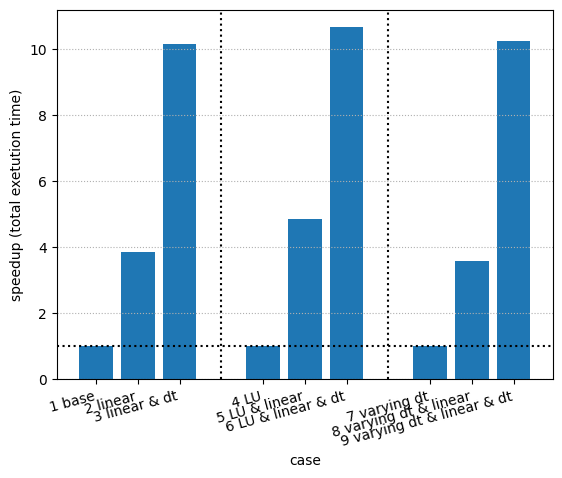

In [16]:
fig, ax = plt.subplots()

ax.bar([i + i // 3 for i in range(len(cases))], height=speedups)
ax.set_xticks([i + i // 3 for i in range(len(cases))])
ax.set_xticklabels([name for name, case in cases], rotation=15, ha="right")
ax.set_ylabel("speedup (total exetution time)")
ax.set_xlabel("case")
ax.grid(axis="y", ls=":")
ax.axhline(1, color="k", ls=":")
ax.axvline(3, color="k", ls=":")
ax.axvline(7, color="k", ls=":")

## Median timestep timings

In [17]:
df_median_time_step_timings = df_stats.groupby("case_name").median()

In [18]:
df_time_step_speedups = df_median_time_step_timings.copy(deep=True)
# Attention: relies on right order of the dataframe index
assert np.all(df_time_step_speedups.index == [name for name, case in cases])

# normalize by iteration number
df_time_step_speedups["assembly_time"] /= df_time_step_speedups["iteration_number"]
df_time_step_speedups["linear_solver_time"] /= df_time_step_speedups["iteration_number"]
df_time_step_speedups["dirichlet_time"] /= df_time_step_speedups["iteration_number"]

for col in df_time_step_speedups.columns:
    c = df_time_step_speedups[col].to_numpy()
    # c[:3] = np.max(c[:3]) / c[:3]
    # c[3:] = np.max(c[3:]) / c[3:]
    c[:3] = c[0] / c[:3]
    c[3:6] = c[3] / c[3:6]
    c[6:] = c[6] / c[6:]
    assert len(c) == 9

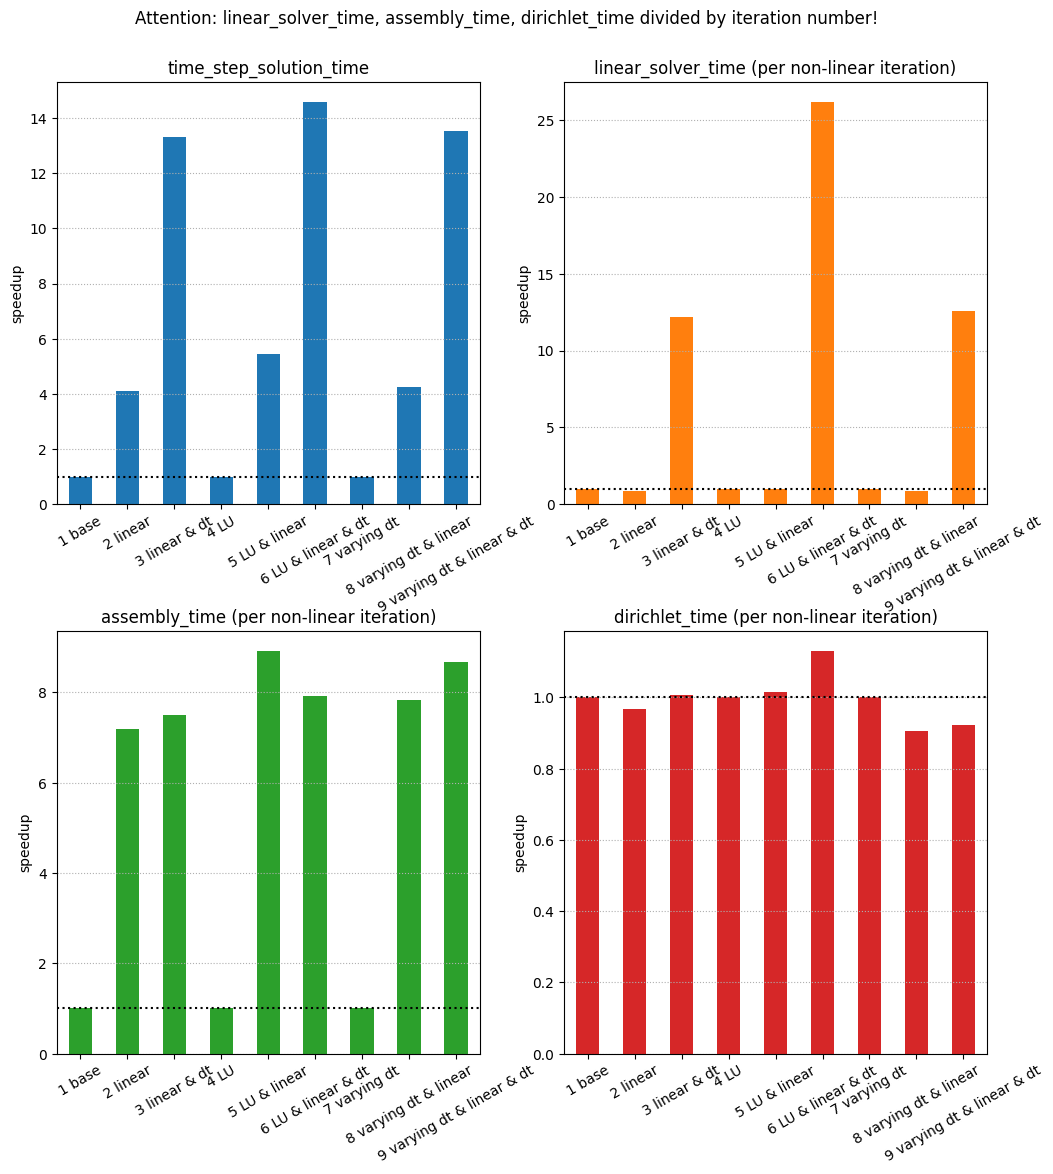

In [19]:
axs = df_time_step_speedups[
    ["time_step_solution_time", "linear_solver_time", "assembly_time", "dirichlet_time"]
].plot(
    kind="bar",
    rot=30,
    subplots=True,
    layout=(2, 2),
    sharex=False,
    sharey=False,
    legend=False,
    xlabel="",
    ylabel="speedup",
    ylim=0,
    title="Attention: linear_solver_time, assembly_time, dirichlet_time divided by iteration number!",
    figsize=(12, 12),
)
for ax in axs.ravel():
    ax.grid(axis="y", ls=":")
    ax.axhline(1, ls=":", color="k")
    title = ax.get_title()
    if title != "time_step_solution_time":
        ax.set_title(title + " (per non-linear iteration)")

axs.ravel()[0].get_figure().subplots_adjust(top=0.92, hspace=0.3)

In [20]:
df_time_step_speedups = df_median_time_step_timings.copy(deep=True)
# Attention: relies on right order of the dataframe index
assert np.all(df_time_step_speedups.index == [name for name, case in cases])

for col in df_time_step_speedups.columns:
    c = df_time_step_speedups[col].to_numpy()
    # c[:3] = np.max(c[:3]) / c[:3]
    # c[3:] = np.max(c[3:]) / c[3:]
    c[:3] = c[0] / c[:3]
    c[3:] = c[3] / c[3:]

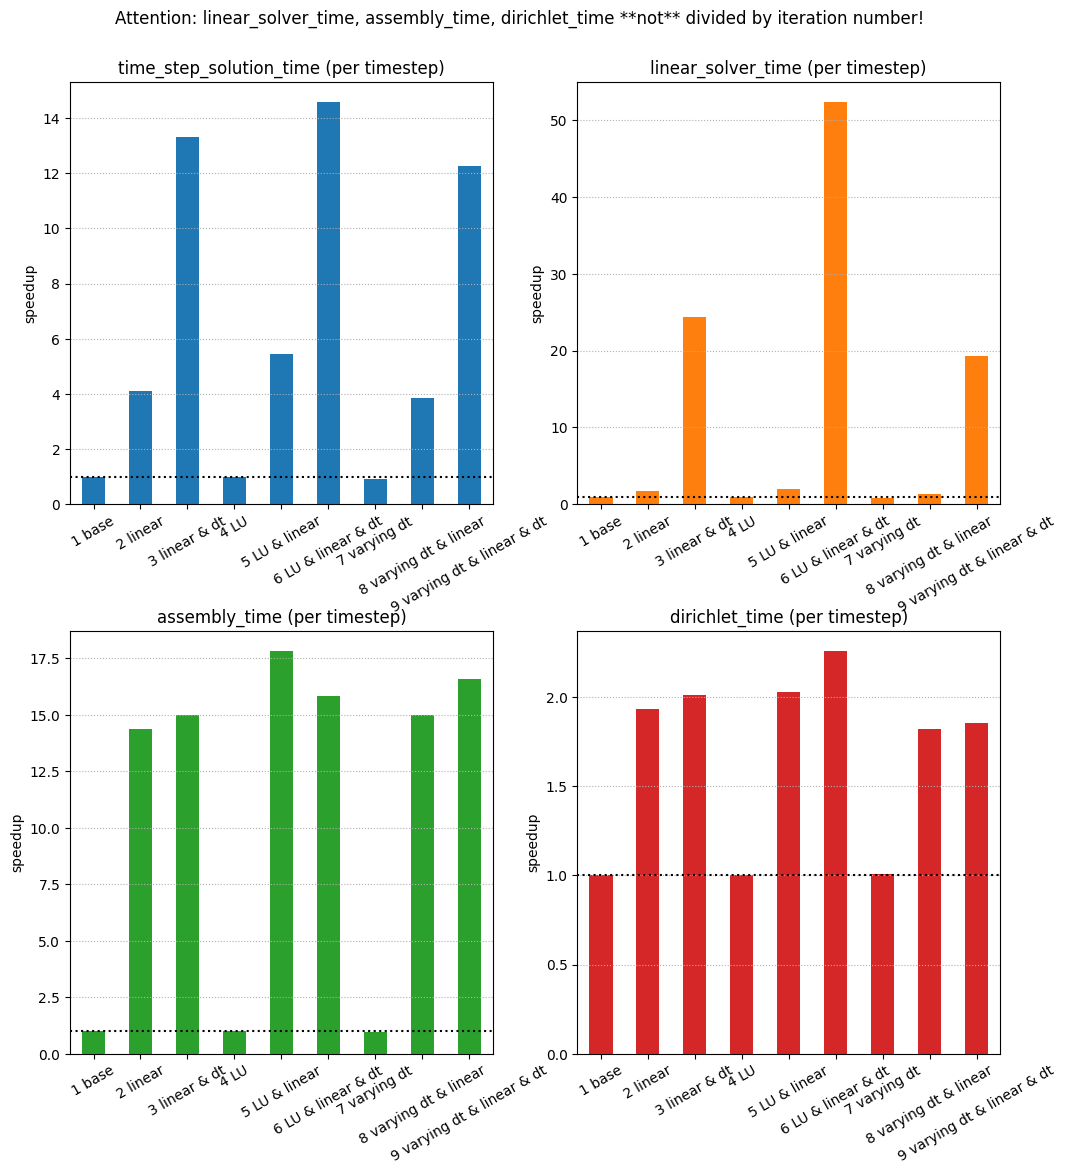

In [21]:
axs = df_time_step_speedups[
    ["time_step_solution_time", "linear_solver_time", "assembly_time", "dirichlet_time"]
].plot(
    kind="bar",
    rot=30,
    subplots=True,
    layout=(2, 2),
    sharex=False,
    sharey=False,
    legend=False,
    xlabel="",
    ylabel="speedup",
    ylim=0,
    title="Attention: linear_solver_time, assembly_time, dirichlet_time **not** divided by iteration number!",
    figsize=(12, 12),
)
for ax in axs.ravel():
    ax.grid(axis="y", ls=":")
    ax.axhline(1, ls=":", color="k")
    ax.set_title(ax.get_title() + " (per timestep)")

axs.ravel()[0].get_figure().subplots_adjust(top=0.92, hspace=0.3)

# Number of linear solves

In [22]:
computes = []
solves = []

for _name, case in cases:
    outdir = get_out_dir(case)
    logfile = outdir / "ogs-out.txt"

    res = subprocess.run(
        f'grep "compute with Eigen .* linear solver" {logfile} | wc -l',
        shell=True,
        check=True,
        capture_output=True,
    )
    comp = int(res.stdout)

    res = subprocess.run(
        f'grep "solve with Eigen .* linear solver" {logfile} | wc -l',
        shell=True,
        check=True,
        capture_output=True,
    )
    solv = int(res.stdout)

    computes.append(comp)
    solves.append(solv)

In [23]:
df_solves = pd.DataFrame.from_dict(
    {
        "computes": computes,
        "solves": solves,
        "case_name": [name for name, case in cases],
    }
).set_index("case_name")

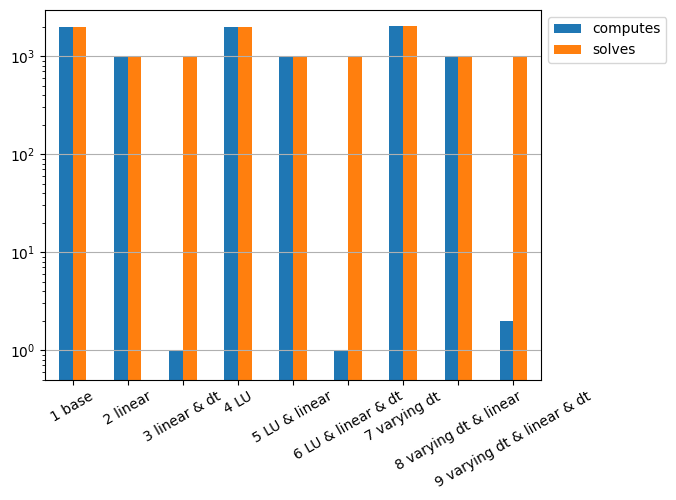

In [24]:
ax = df_solves.plot(kind="bar", rot=30, logy=True, legend=False, xlabel="")
ax.grid(axis="y")
ax.set_ylim(0.5)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [25]:
case_base = df_solves.loc["1 base"]
assert case_base["computes"] == case_base["solves"]

case_linear = df_solves.loc["2 linear"]
assert case_linear["computes"] == case_linear["solves"]
assert 2 * case_linear["computes"] == case_base["computes"]

case_linear_dt = df_solves.loc["3 linear & dt"]
assert case_linear_dt["computes"] == 1
assert case_linear_dt["solves"] == case_linear["solves"]

In [26]:
case_lu_base = df_solves.loc["4 LU"]
assert case_lu_base["computes"] == case_lu_base["solves"]

case_linear = df_solves.loc["5 LU & linear"]
assert case_linear["computes"] == case_linear["solves"]
assert 2 * case_linear["computes"] == case_lu_base["computes"]

case_linear_dt = df_solves.loc["6 LU & linear & dt"]
assert case_linear_dt["computes"] == 1
assert case_linear_dt["solves"] == case_linear["solves"]

In [27]:
case_dt_base = df_solves.loc["7 varying dt"]
assert case_dt_base["computes"] == case_dt_base["solves"]

case_linear = df_solves.loc["8 varying dt & linear"]
assert case_linear["computes"] == case_linear["solves"]
assert 2 * case_linear["computes"] == case_dt_base["computes"]

case_linear_dt = df_solves.loc["9 varying dt & linear & dt"]
assert case_linear_dt["computes"] == 2
assert case_linear_dt["solves"] == case_linear["solves"]

# Cross-validate results with base case

In [28]:
import pyvista as pv

In [29]:
# read all data
simulation_results = {}

for name, case in cases:
    pvdfile = get_out_dir(case) / "1d_decay_chain_GIA.pvd"
    print("reading", pvdfile)
    reader = pv.get_reader(pvdfile)
    # print(reader.time_values)

    ts = reader.time_values
    meshes = []

    for ti, _t in enumerate(ts):
        reader.set_active_time_point(ti)
        meshes.append(reader.read()[0])

    simulation_results[name] = {"t": ts, "meshes": meshes}

reading _out/./1d_decay_chain_GIA.pvd
reading _out/linear/1d_decay_chain_GIA.pvd
reading _out/linear_compute_only_on_dt_change/1d_decay_chain_GIA.pvd
reading _out/SparseLU/1d_decay_chain_GIA.pvd
reading _out/SparseLU_linear/1d_decay_chain_GIA.pvd
reading _out/SparseLU_linear_compute_only_on_dt_change/1d_decay_chain_GIA.pvd
reading _out/varying_dt/1d_decay_chain_GIA.pvd
reading _out/varying_dt_linear/1d_decay_chain_GIA.pvd
reading _out/varying_dt_linear_compute_only_on_dt_change/1d_decay_chain_GIA.pvd


In [32]:
def compare_optimizations_to_base_case(cases):
    """Checks that all fields from the optimized cases (<linear>, <compute_only_...>) are within a very tight tolerance to the base case (not <linear>)"""

    base_case_name = cases[0][0]
    base_ts = simulation_results[base_case_name]["t"]
    base_meshes = simulation_results[base_case_name]["meshes"]

    checked_point_data = set()
    checked_cell_data = set()
    checked_field_data = set()

    for name, _case in cases[1:3]:
        print(f"checking case '{name}'")
        var_ts = simulation_results[name]["t"]
        var_meshes = simulation_results[name]["meshes"]

        assert np.allclose(base_ts, var_ts, atol=1e-15, rtol=0)

        for bm, vm in zip(base_meshes, var_meshes):
            # point coordinates
            assert np.allclose(bm.points, vm.points, atol=1e-15, rtol=0)

            for n in bm.point_data:
                checked_point_data.add(n)
                try:
                    assert np.allclose(
                        bm.point_data[n], vm.point_data[n], atol=1e-15, rtol=0
                    )
                except:
                    print(f"error in nodal field '{n}'")
                    raise

            for n in bm.cell_data:
                checked_cell_data.add(n)
                assert np.allclose(bm.cell_data[n], vm.cell_data[n], atol=1e-15, rtol=0)

            for n in bm.field_data:
                checked_field_data.add(n)
                assert np.allclose(
                    bm.field_data[n], vm.field_data[n], atol=1e-15, rtol=0
                )

    print("checked point data:", sorted(checked_point_data))

    checked_point_data_expected = [
        "LiquidMassFlowRate",
        "[Ac-227]",
        "[Ac-227]FlowRate",
        "[Ac-227]Flux",
        "[Am-243]",
        "[Am-243]FlowRate",
        "[Am-243]Flux",
        "[Cm-247]",
        "[Cm-247]FlowRate",
        "[Cm-247]Flux",
        "[Pa-231]",
        "[Pa-231]FlowRate",
        "[Pa-231]Flux",
        "[Pu-239]",
        "[Pu-239]FlowRate",
        "[Pu-239]Flux",
        "[U-235]",
        "[U-235]FlowRate",
        "[U-235]Flux",
        "pressure",
    ]
    assert (
        len(checked_point_data.symmetric_difference(checked_point_data_expected)) == 0
    )

    print("checked cell data:", sorted(checked_cell_data))

    print("checked field data:", sorted(checked_field_data))

In [34]:
compare_optimizations_to_base_case(cases[:3])
compare_optimizations_to_base_case(cases[3:6])
compare_optimizations_to_base_case(cases[6:])

checking case '2 linear'
checking case '3 linear & dt'
checked point data: ['LiquidMassFlowRate', '[Ac-227]', '[Ac-227]FlowRate', '[Am-243]', '[Am-243]FlowRate', '[Cm-247]', '[Cm-247]FlowRate', '[Pa-231]', '[Pa-231]FlowRate', '[Pu-239]', '[Pu-239]FlowRate', '[U-235]', '[U-235]FlowRate', 'pressure']
checked cell data: []
checked field data: ['OGS_VERSION']
checking case '5 LU & linear'
checking case '6 LU & linear & dt'
checked point data: ['LiquidMassFlowRate', '[Ac-227]', '[Ac-227]FlowRate', '[Am-243]', '[Am-243]FlowRate', '[Cm-247]', '[Cm-247]FlowRate', '[Pa-231]', '[Pa-231]FlowRate', '[Pu-239]', '[Pu-239]FlowRate', '[U-235]', '[U-235]FlowRate', 'pressure']
checked cell data: []
checked field data: ['OGS_VERSION']
checking case '8 varying dt & linear'
checking case '9 varying dt & linear & dt'
checked point data: ['LiquidMassFlowRate', '[Ac-227]', '[Ac-227]FlowRate', '[Am-243]', '[Am-243]FlowRate', '[Cm-247]', '[Cm-247]FlowRate', '[Pa-231]', '[Pa-231]FlowRate', '[Pu-239]', '[Pu-239]F